<a href="https://colab.research.google.com/github/Ahntea/pytorch_from_scratch/blob/main/age_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.font_manager as fm
import os

!apt-get -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()
# 단계 3: 한글 폰트 설정
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

# 마이너스 표시 문제
mpl.rcParams['axes.unicode_minus'] = False
	
# 한글 폰트 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf'
font_name = fm.FontProperties(fname=path, size=18).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

filename = "/content/drive/MyDrive/thumbnail_list.txt"
import unicodedata

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 한글 변환
name_list = []
with open(filename) as f:
    for line in f:
        name_list.append(unicodedata.normalize("NFC", line.strip()))

In [3]:
# thumbnail dataframe 생성
thumbnail = pd.DataFrame(name_list)
thumbnail["image"]= thumbnail[0].str.replace('_PMT.jpg', '.jpg')
thumbnail.rename(columns = {0:"filename"}, inplace = True)

In [4]:
# image 생성날짜 dataframe 로드 및 merge
imt = pd.read_csv("/content/drive/MyDrive/csv_image_table_1015.csv")

merged = pd.merge(thumbnail, imt, how="left", on = "image" )
merged['gen_date'] = pd.to_datetime(merged[['year','month','day']], format='%Y%m%d')
merged["birth_date"] = merged["image"].str.split('_', expand=True)[2]
merged["birth_date"] = merged["birth_date"].astype("datetime64[ns]")
merged["age"] = (merged["gen_date"] - merged["birth_date"]) / np.timedelta64(1, 'Y')
merged["age"].fillna(35, inplace=True)
merged["age"] = merged["age"].astype(int)
merged.loc[merged["age"]==119, "age"] = 19
merged["category"] = merged["image"].str.split('_', expand=True)[4]
d_ages = merged[['filename','age']].set_index('filename').T.to_dict('list')

In [5]:
# train 데이터 셋 생성
import os

dir_list = []
jpg_list = []
def search(dirname):
    filenames = os.listdir(dirname)
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        ext = os.path.splitext(full_filename)[-1]
        if ext != '.py': 
            dir_list.append(full_filename)

def search2(dirname):
    filenames = os.listdir(dirname)
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        ext = os.path.splitext(full_filename)[-1]
        if ext == '.jpg': 
            jpg_list.append(full_filename)
            
 # 폴더 경로
path = '/content/drive/MyDrive/thumbnail'
search(path)
for dl in dir_list:
  search2(dl)

In [6]:

# os.chdir(path) # 해당 폴더로 이동
# files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
x_train = np.empty((0,28800))
train_names = []
i = 0
for f in jpg_list[:1000]:
  train_names.append(unicodedata.normalize("NFC", f.split('/')[6]))
  temp = np.array(Image.open(f))
  # print(f)
  if temp.shape == (96, 100, 3):
    x_train = np.append(x_train, temp.reshape(1,28800),axis=0)
    # print(x_train.shape)
x_train = x_train.astype(np.float32)

y_train = np.array([])
for n in train_names:
  # print(merged.loc[merged["filename"]==n, "age"])
  y_train = np.append(y_train, merged.loc[merged["filename"]==n, "age"].to_numpy())
y_train = y_train.astype(np.float32)

In [7]:
# test 데이터 셋 생성
path = '/content/drive/MyDrive/test'
os.chdir(path) # 해당 폴더로 이동
files = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
x_valid = np.empty((0,28800))
valid_names = []
for f in files:
  valid_names.append(unicodedata.normalize("NFC", f))
  temp = np.array(Image.open(f))
  if temp.shape == (96, 100, 3):
    # print(temp.reshape(28800))
    x_valid = np.append(x_valid, temp.reshape(1,28800), axis=0)
x_valid = x_valid.astype(np.float32)

y_valid = np.array([])
for n in valid_names:
  # print(merged.loc[merged["filename"]==n, "age"])
  y_valid = np.append(y_valid, merged.loc[merged["filename"]==n, "age"].to_numpy())
y_valid = y_valid.astype(np.float32)

In [8]:
# 모델 선언
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train/255, y_train, x_valid/255, y_valid)
)
print(x_train.shape)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

torch.Size([979, 28800])
tensor([[0.1529, 0.2039, 0.4706,  ..., 0.0275, 0.0235, 0.0471],
        [0.0902, 0.1255, 0.3412,  ..., 0.0235, 0.0275, 0.0353],
        [0.1843, 0.2314, 0.5137,  ..., 0.1294, 0.1725, 0.3843],
        ...,
        [0.1020, 0.1647, 0.4078,  ..., 0.0980, 0.1608, 0.3647],
        [0.1059, 0.1608, 0.4000,  ..., 0.7216, 0.6471, 0.3373],
        [0.1059, 0.1804, 0.4392,  ..., 0.1020, 0.1608, 0.3765]]) tensor([35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35., 35.,
        35., 35., 35., 35., 35., 35., 35., 31., 31., 31., 26., 26., 26., 26.,
        26., 26., 26., 26., 26., 26., 26., 26., 26., 26., 26., 26., 26., 26.,
        26., 26., 26., 26., 26., 26., 26., 26., 26., 26., 26., 26., 26., 26.,
        26., 26., 26., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
        25., 25., 25., 25., 25., 25., 35., 35., 35., 35., 35., 35., 35., 35.,
        35., 35., 35., 35., 35.

In [9]:
import math

weights = torch.randn(28800, 1) / math.sqrt(28800)
weights.requires_grad_()
bias = torch.zeros(1, requires_grad=True)

model = nn.Linear(28800,1)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5) 

nb_epochs = 2000
for epoch in range(nb_epochs+1):

    # H(x) 계산
    prediction = model(x_train)
    # model(x_train)은 model.forward(x_train)와 동일함.

    # cost 계산
    cost = F.mse_loss(prediction, y_train) # <== 파이토치에서 제공하는 평균 제곱 오차 함수

    # cost로 H(x) 개선하는 부분
    # gradient를 0으로 초기화
    optimizer.zero_grad()
    # 비용 함수를 미분하여 gradient 계산
    cost.backward()
    # W와 b를 업데이트
    optimizer.step()

    if epoch % 100 == 0:
    # 100번마다 로그 출력
      print('Epoch {:4d}/{} Cost: {:.6f}'.format(
          epoch, nb_epochs, cost.item()
      ))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Using a target size (torch.Size([1000])) that is different to the input size (torch.Size([979, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch    0/2000 Cost: 1377.721191
Epoch  100/2000 Cost: 152.823837
Epoch  200/2000 Cost: 143.820984
Epoch  300/2000 Cost: 137.546127
Epoch  400/2000 Cost: 133.127609
Epoch  500/2000 Cost: 129.984360
Epoch  600/2000 Cost: 127.722168
Epoch  700/2000 Cost: 126.072418
Epoch  800/2000 Cost: 124.851410
Epoch  900/2000 Cost: 123.932762
Epoch 1000/2000 Cost: 123.229233
Epoch 1100/2000 Cost: 122.680099
Epoch 1200/2000 Cost: 122.242973
Epoch 1300/2000 Cost: 121.887993
Epoch 1400/2000 Cost: 121.593994
Epoch 1500/2000 Cost: 121.345818
Epoch 1600/2000 Cost: 121.132576
Epoch 1700/2000 Cost: 120.946350
Epoch 1800/2000 Cost: 120.781349
Epoch 1900/2000 Cost: 120.633217
Epoch 2000/2000 Cost: 120.498756


In [10]:
pred_y = []

In [11]:
for i in range(len(x_valid)):
  pred_y.append(model(x_valid[i]).detach().item())

In [12]:
print(len(y_valid), len(pred_y))

86 153


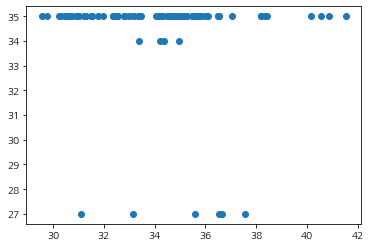

In [13]:
plt.scatter(pred_y[:86], y_valid)

In [14]:
class LinearRegressionModel(nn.Module): # torch.nn.Module을 상속받는 파이썬 클래스
    def __init__(self): #
        super().__init__()
        self.linear = nn.Linear(28800, 1) # 단순 선형 회귀이므로 input_dim=1, output_dim=1.

    def forward(self, x):
        return self.linear(x)

In [15]:
model = LinearRegressionModel()